In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from helper_functions import set_seeds, train
from torch import nn
from torch.utils.data.dataloader import DataLoader
from torchinfo import summary
from torchvision import datasets, transforms


In [2]:
set_seeds(42)

In [3]:
image_path = Path("data/pizza_steak_sushi")

In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"


In [5]:
img_size = 224

basic_transform = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ]
)


In [6]:
train_dataset = datasets.ImageFolder(train_dir, transform=basic_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=basic_transform)


In [7]:
train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [8]:
batch_size = 32
num_workers = os.cpu_count()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
    shuffle=True,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True,
    shuffle=True,
)


In [9]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label


(torch.Size([3, 224, 224]), tensor(2))

In [10]:
classes = train_dataset.classes

(-0.5, 223.5, 223.5, -0.5)

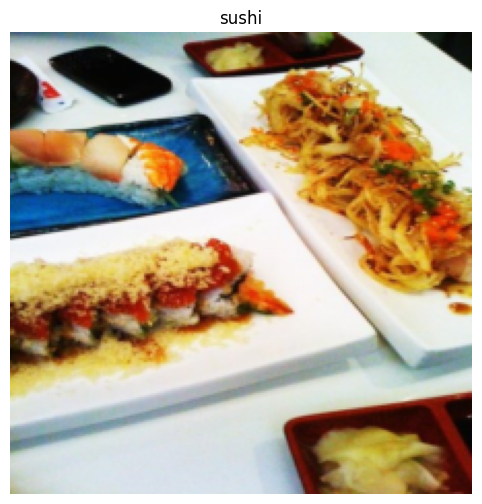

In [11]:
plt.figure(figsize=(10, 6))
plt.imshow(image.permute(1, 2, 0))
plt.title(classes[label])
plt.axis(False)


In [12]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = int((height * width) / patch_size**2)
print(
    f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}"
)


Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [13]:
embedding_layer_input_shape = (height, width, color_channels)

embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(
    f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}"
)


Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


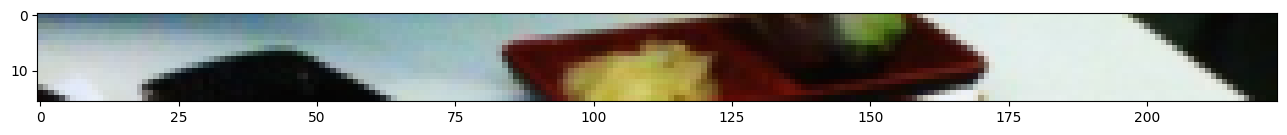

In [14]:
image_permuted = image.permute(1, 2, 0)

plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);


Number of patches per row 14
Number of patches per column 14
Total patches: 196
Patch size: 16 pixels x 16 pixels


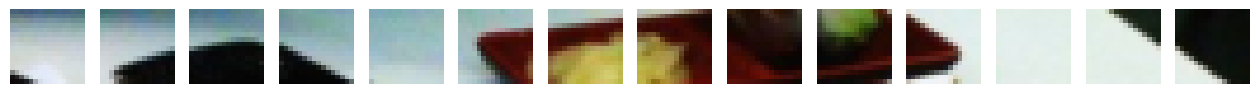

In [15]:
num_patches = img_size // patch_size
assert img_size % patch_size == 0
print(
    f"Number of patches per row {num_patches}\nNumber of patches per column {num_patches}\nTotal patches: {num_patches*num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels"
)

plt.figure(figsize=(patch_size, patch_size))
for i, patch in enumerate(range(0, img_size, patch_size)):
    plt.subplot(1, num_patches, i + 1)
    plt.imshow(image_permuted[:patch_size, patch : patch + patch_size, :])
    plt.xlabel(i + 1)
    plt.axis(False)


Text(0.5, 0.98, 'sushi -> Patchified')

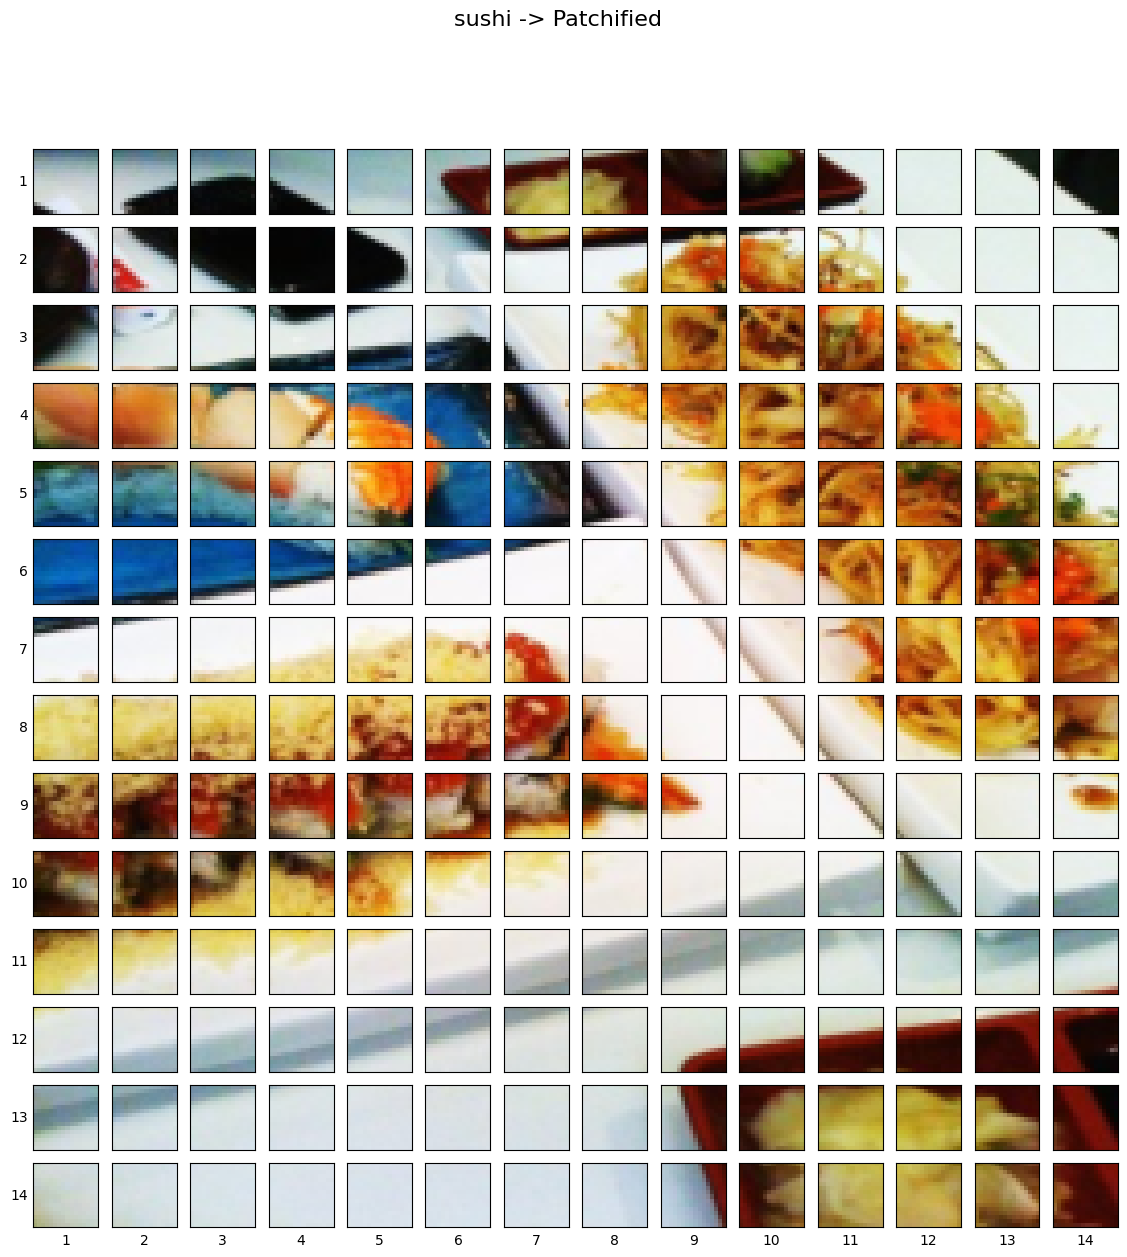

In [16]:
fig, axs = plt.subplots(
    nrows=num_patches,
    ncols=num_patches,
    figsize=(num_patches, num_patches),
    sharex=True,
    sharey=True,
)

# Loop through height and width of image
for i, patch_height in enumerate(
    range(0, img_size, patch_size)
):  # iterate through height
    for j, patch_width in enumerate(
        range(0, img_size, patch_size)
    ):  # iterate through width
        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(
            image_permuted[
                patch_height : patch_height + patch_size,  # iterate through height
                patch_width : patch_width + patch_size,  # iterate through width
                :,
            ]
        )  # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(
            i + 1,
            rotation="horizontal",
            horizontalalignment="right",
            verticalalignment="center",
        )
        axs[i, j].set_xlabel(j + 1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{classes[label]} -> Patchified", fontsize=16)


In [17]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """

    # 2. Initialize the class with appropriate variables
    def __init__(
        self, in_channels: int = 3, patch_size: int = 16, embedding_dim: int = 768
    ):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0,
        )

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(
            start_dim=2,  # only flatten the feature map dimensions into a single vector
            end_dim=3,
        )

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert (
            image_resolution % patch_size == 0
        ), f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(
            0, 2, 1
        )  # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]


In [18]:
patchify = PatchEmbedding()

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output patch embedding image shape: {patch_embedded_image.shape}")


Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding image shape: torch.Size([1, 196, 768])


In [19]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short)."""

    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(
        self,
        embedding_dim: int = 768,  # Hidden size D from Table 1 for ViT-Base
        num_heads: int = 12,  # Heads from Table 1 for ViT-Base
        attn_dropout: float = 0,
    ):  # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True,
        )  # does our batch dimension come first?

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(
            query=x,  # query embeddings
            key=x,  # key embeddings
            value=x,  # value embeddings
            need_weights=False,
        )  # do we need the weights or just the layer outputs?
        return attn_output


In [20]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""

    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(
        self,
        embedding_dim: int = 768,  # Hidden Size D from Table 1 for ViT-Base
        mlp_size: int = 3072,  # MLP size from Table 1 for ViT-Base
        dropout: float = 0.1,
    ):  # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),  # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(
                in_features=mlp_size,  # needs to take same in_features as out_features of layer above
                out_features=embedding_dim,
            ),  # take back to embedding_dim
            nn.Dropout(
                p=dropout
            ),  # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x


In [21]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""

    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(
        self,
        embedding_dim: int = 768,  # Hidden size D from Table 1 for ViT-Base
        num_heads: int = 12,  # Heads from Table 1 for ViT-Base
        mlp_size: int = 3072,  # MLP size from Table 1 for ViT-Base
        mlp_dropout: float = 0.1,  # Amount of dropout for dense layers from Table 3 for ViT-Base
        attn_dropout: float = 0,
    ):  # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(
            embedding_dim=embedding_dim, num_heads=num_heads, attn_dropout=attn_dropout
        )

        # 4. Create MLP block (equation 3)
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim, mlp_size=mlp_size, dropout=mlp_dropout
        )

    # 5. Create a forward() method
    def forward(self, x):
        # 6. Create residual connection for MSA block (add the input to the output)
        x = self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x


In [22]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""

    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(
        self,
        img_size: int = 224,  # Training resolution from Table 3 in ViT paper
        in_channels: int = 3,  # Number of channels in input image
        patch_size: int = 16,  # Patch size
        num_transformer_layers: int = 12,  # Layers from Table 1 for ViT-Base
        embedding_dim: int = 768,  # Hidden size D from Table 1 for ViT-Base
        mlp_size: int = 3072,  # MLP size from Table 1 for ViT-Base
        num_heads: int = 12,  # Heads from Table 1 for ViT-Base
        attn_dropout: float = 0,  # Dropout for attention projection
        mlp_dropout: float = 0.1,  # Dropout for dense/MLP layers
        embedding_dropout: float = 0.1,  # Dropout for patch and position embeddings
        num_classes: int = 1000,
    ):  # Default for ImageNet but can customize this
        super().__init__()  # don't forget the super().__init__()!

        # 3. Make the image size is divisble by the patch size
        assert (
            img_size % patch_size == 0
        ), f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(
            data=torch.randn(1, 1, embedding_dim), requires_grad=True
        )

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(
            data=torch.randn(1, self.num_patches + 1, embedding_dim), requires_grad=True
        )

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(
            in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim
        )

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(
            *[
                TransformerEncoderBlock(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    mlp_size=mlp_size,
                    mlp_dropout=mlp_dropout,
                )
                for _ in range(num_transformer_layers)
            ]
        )

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes),
        )

    # 11. Create a forward() method
    def forward(self, x):
        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(
            batch_size, -1, -1
        )  # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0])  # run on each sample in a batch at 0 index

        return x


In [23]:
# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(
    1, 3, 224, 224
)  # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(classes))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)


tensor([[-0.7206, -0.0837, -0.0312]], grad_fn=<AddmmBackward0>)

In [24]:
summary(
    model=vit,
    input_size=(32, 3, 224, 224),  # (batch_size, color_channels, height, width)
    # col_names=["input_size"], # uncomment for smaller output
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [25]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(
    params=vit.parameters(),
    lr=3e-3,  # Base LR from Table 3 for ViT-* ImageNet-1k
    betas=(
        0.9,
        0.999,
    ),  # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
    weight_decay=0.3,
)  # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()


# Train the model and save the training results to a dictionary
results = train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device="cpu",
)


  0%|          | 0/10 [00:00<?, ?it/s]